# Here, we integrate datasets from the embryonic and early postnatal mouse heart and the human fetal heart. 

In [1]:
# Import the required packages
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scib_metrics.benchmark import Benchmarker
from mousipy import translate
import scanorama
import scvi
import pyliger
from harmony import harmonize
import bbknn


# Below is to ensure Scanorama can run by fixing the error of deprecated 'collections.MutableSet' function
import collections 
import sys
if sys.version_info.major == 3 and sys.version_info.minor >= 10:
    from collections.abc import MutableSet
    collections.MutableSet = collections.abc.MutableSet
else: 
    from collections import MutableSet

sc.settings.set_figure_params(
    frameon=False,
    vector_friendly=False,
    dpi=100,
    dpi_save=700
)

In [2]:
#Mouse dataset
adata = sc.read('/mnt/sdb/qdang/singlecell/epi/integrated/mouse_integrated_epionly_scgen.h5ad')

In [3]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 4374 × 22400
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell type_colors', 'celltypist_cell_label_PRJNA795900_colors', 'dea_leiden_0_5', 'dendrogram_cell type', 'dendrogram_cell type 2', 'd

In [6]:
# Set the .X layer to raw counts to prepare for integration
adata.layers['counts'] = adata.X.copy()

In [33]:
#Human dataset
adata2 = sc.read('/mnt/sdb/qdang/singlecell/human/naive/fullgene_epionly_filtered.h5ad')

In [34]:
adata2 = adata2.raw.to_adata()
adata2

AnnData object with n_obs × n_vars = 2205 × 39077
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'n_cells'
    uns: 'Batch_colors', 'celltypist_cell_label_kundaje_colors', 'leiden', 'leiden_res0_25_colors', 'log1p', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap'
    obsm: 'BBKNN', 'Harmony', 'LIGER', 'Scanorama', 'Seurat', 'Unintegrated', 'X_pca', 'X_umap', 'scANVI', 'scGen', 'scVI'
    obsp: 'connectivities', 'distances'

In [37]:
# List independent datasets in the integrated data
adata2.obs['Batch']

AAAGAACAGTGGTTGG-1    PMID_36938497_Sinha
AACAGGGCATCCGATA-1    PMID_36938497_Sinha
AAGAACAGTACGAGCA-1    PMID_36938497_Sinha
AATCGTGAGAATGTTG-1    PMID_36938497_Sinha
ACCTACCGTCGTGGTC-1    PMID_36938497_Sinha
                             ...         
TTAGCAGGTTAGTACG-1     PMID_37676760_Lien
TTGACTAAGGTCCTGA-1     PMID_37676760_Lien
TTGGTGAGTTCAAGCA-1     PMID_37676760_Lien
TTTGACTTCTGTTCAT-1     PMID_37676760_Lien
TTTGCGGAGGTCCTGA-1     PMID_37676760_Lien
Name: Batch, Length: 2205, dtype: category
Categories (5, object): ['PMID_30759401_Yan', 'PMID_36563664_Kundaje', 'PMID_36938497_Sinha', 'PMID_37390825_Smits', 'PMID_37676760_Lien']

# Below, we process the human integrated epicardium

In [36]:
# Normalisation and log1p transform
adata2.layers['counts'] = adata2.X.copy()
scales_counts = sc.pp.normalize_total(adata2, target_sum=None, inplace=False)
adata2.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
adata2.X = adata2.layers["log1p_norm"].copy()

0    20798
1    10485
2     4909
3     2022
4      684
5      179
Name: highly_variable_nbatches, dtype: int64

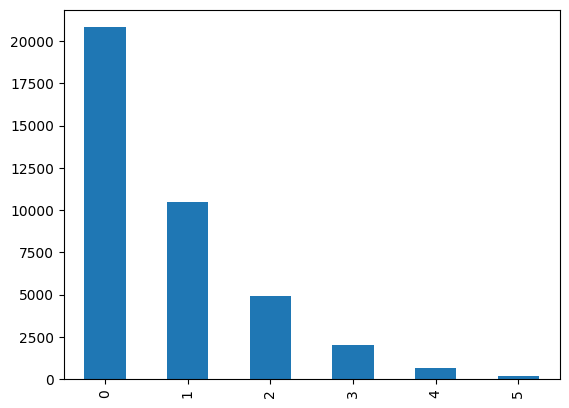

In [38]:
# find highly variable genes in the integrated dataset
sc.pp.highly_variable_genes(
    adata2, n_top_genes=6000, flavor="cell_ranger", batch_key='Batch'
)
n_batches = adata2.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [39]:
# Set the .X layer to normalised, log1p_transformed data
adata2.X = adata2.layers["log1p_norm"]

In [40]:
# Perform UMAP and leiden clustering for unintegrated dataset
sc.pp.pca(adata2, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(adata2)
sc.tl.umap(adata2)
sc.tl.leiden(adata2, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata2, key_added="leiden_res1", resolution=1.0)

2025-03-21 18:02:56.614266: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 18:02:56.641294: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 18:02:56.641314: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 18:02:56.642128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 18:02:56.646606: I tensorflow/core/platform/cpu_feature_guar

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


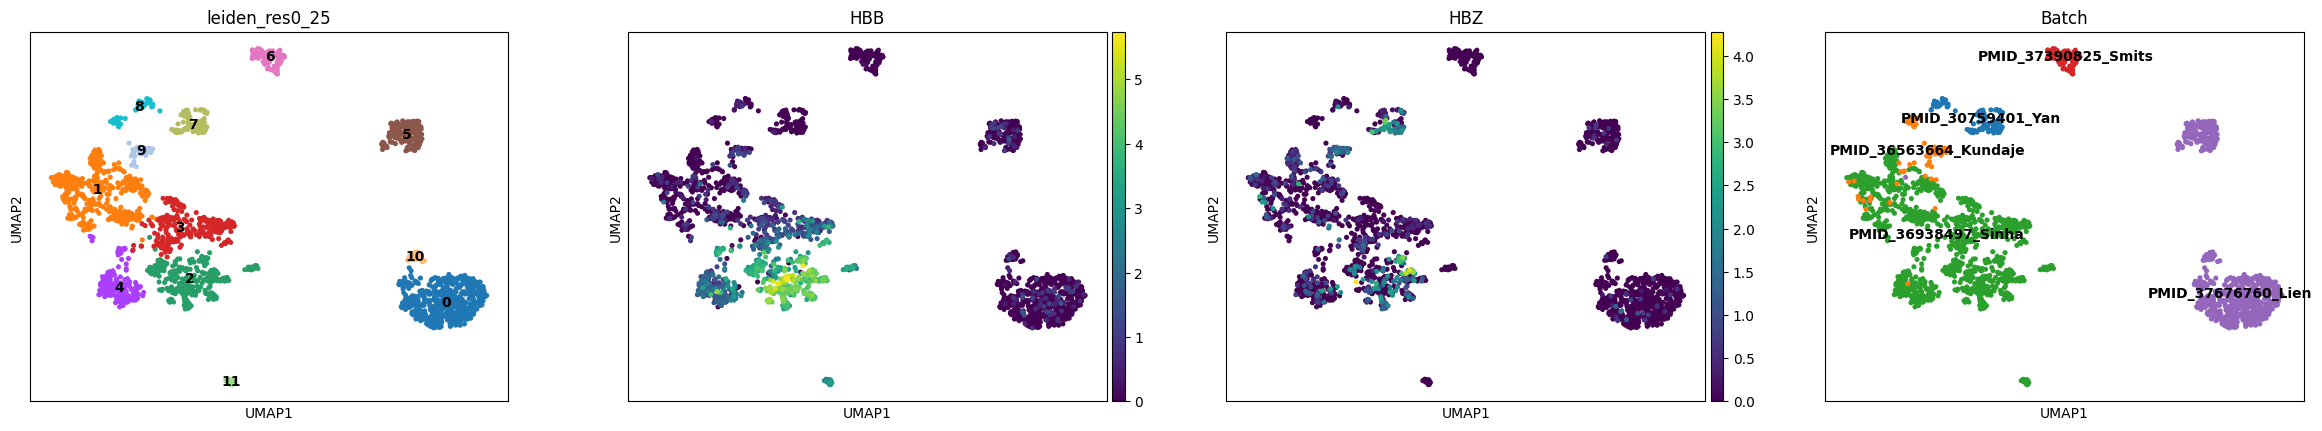

In [41]:
# The dataset is contaminated with red blood cells or low-quality cells, indicating by cells expressing high levels of hemoglobin genes
sc.pl.umap(adata2, color=['leiden_res0_25','HBB','HBZ','Batch'],layer='log1p_norm', legend_loc='on data')

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


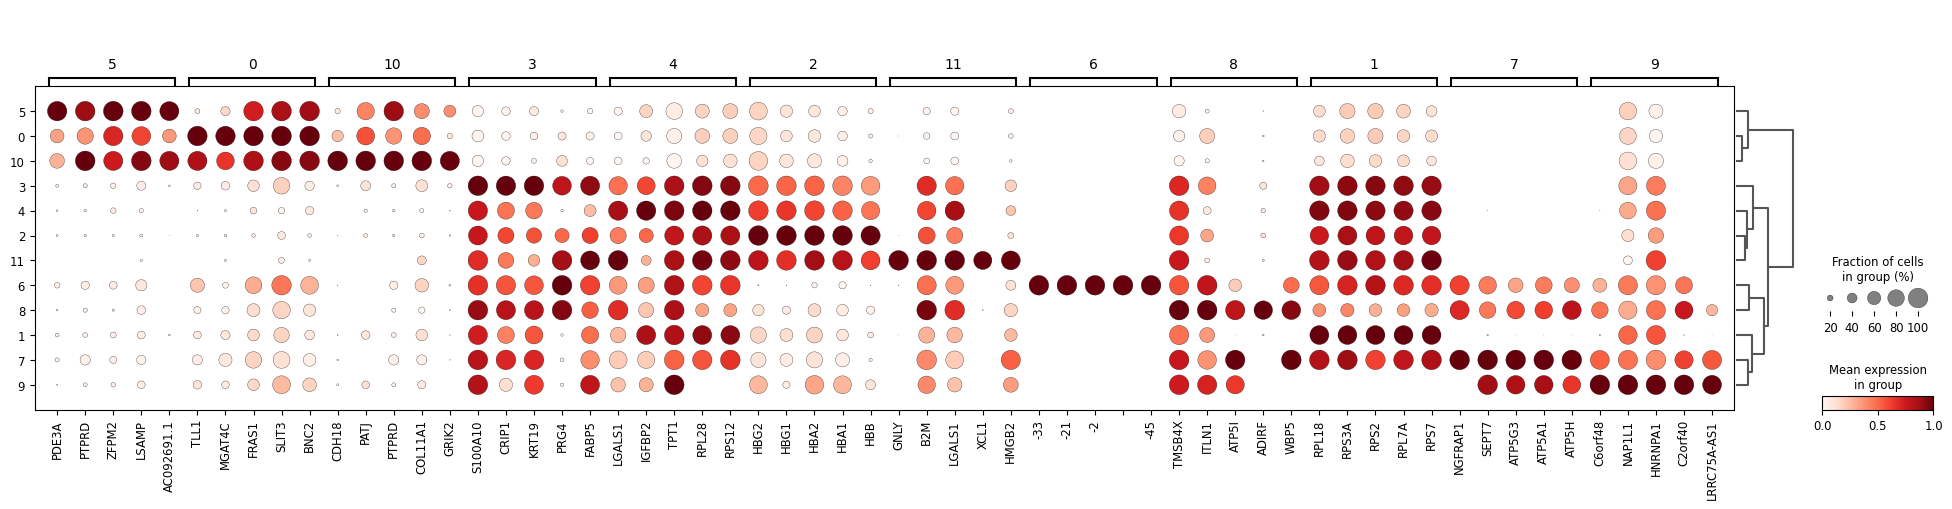

In [42]:
#Calculate the differentially expressed genes for every cluster using the Wilcoxon method, followed by visualsation of expression of the top differentially expressed genes per cluster
# Clusters 1 nad 2 seem to be low-quality cells (expressing ribosomal and hemoglobin genes
sc.tl.dendrogram(adata2, groupby="leiden_res0_25")
sc.tl.rank_genes_groups(
    adata2, groupby="leiden_res0_25", method="wilcoxon", key_added="dea_leiden_0_25"
)
sc.pl.rank_genes_groups_dotplot(
    adata2, groupby="leiden_res0_25", standard_scale="var", n_genes=5, key="dea_leiden_0_25"
)

/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


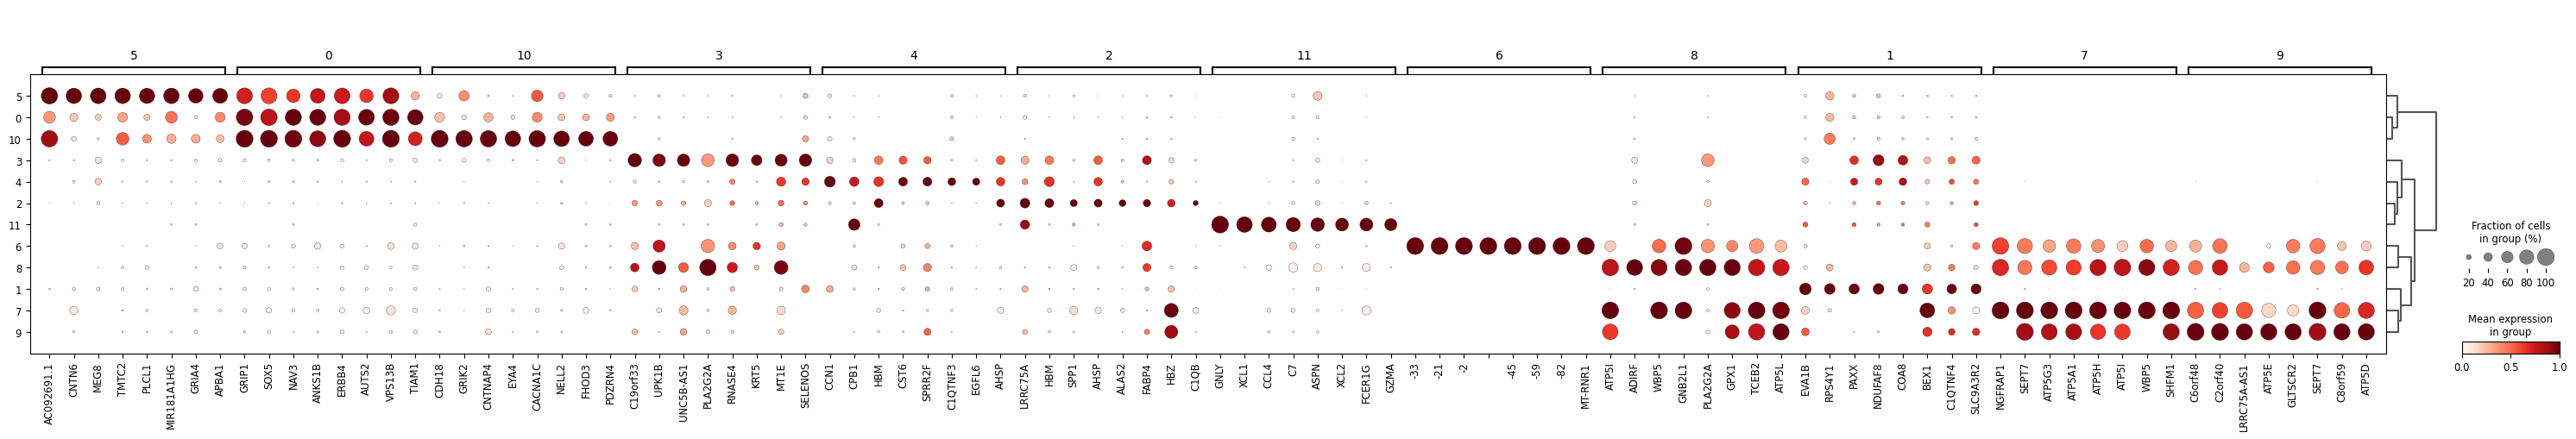

In [43]:
#  filter the differentially expressed genes to select for more cluster-specific differentially expressed genes, and visualise
sc.tl.filter_rank_genes_groups(
    adata2,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_0_25",
    key_added="dea_leiden_0_25_filtered",
)
sc.pl.rank_genes_groups_dotplot(
    adata2,
    groupby="leiden_res0_25",
    standard_scale="var",
    n_genes=8,
    key="dea_leiden_0_25_filtered",
)

In [44]:
adata2

AnnData object with n_obs × n_vars = 2205 × 39077
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Batch_colors', 'celltypist_cell_label_kundaje_colors', 'leiden', 'leiden_res0_25_colors', 'log1p', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap', 'hvg', 'dendrogram_leiden_res0_25', 'dea_leiden_0_25', 'dea_

In [51]:
# Remove clusters of low-quality cells
adata2 = adata2[-adata2.obs['leiden_res0_25'].isin(['1','2'])]
adata2

AnnData object with n_obs × n_vars = 1456 × 39077
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'n_genes', 'barcode', 'Batch', '_scvi_batch', '_scvi_labels', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'leiden_res0_25', 'leiden_res0_5', 'leiden_res1', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Batch_colors', 'celltypist_cell_label_kundaje_colors', 'leiden', 'leiden_res0_25_colors', 'log1p', 'neighbors', 'pca', 'scDblFinder_class_colors', 'umap', 'hvg', 'dendrogram_leiden_res0_25', 'dea_leiden_0_2

# Below, we convert the mouse to human gene symbols for integration. We use mousipy, which is itself based on Biomart conversion of mouse (GRCm39) and human (GRCh38.p13) orthologs

In [17]:
# Perform the conversion
humanized_adata = translate(adata)

100%|██████████| 22400/22400 [00:46<00:00, 483.25it/s]


Found direct orthologs for 14779 genes.
Found multiple orthologs for 260 genes.
Found no orthologs for 5776 genes.
Found no index in biomart for 1585 genes.


100%|██████████| 260/260 [00:09<00:00, 26.86it/s]
/home/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
# Convert the .X layer to sparse matrix
from scipy import sparse

sparse_X = sparse.csr_matrix(humanized_adata.X)
humanized_adata.X = sparse_X

In [88]:
humanized_adata

AnnData object with n_obs × n_vars = 4374 × 15986
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'original_gene_symbol'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell type_colors', 'celltypist_cell_label_PRJNA795900_colors', 'dea_leiden_0_5', 'dendrogram_cell type', 'den

In [95]:
epi = {"mouse": humanized_adata, "human": adata2}
epi = ad.concat(epi, label="Species", join="outer")
epi

AnnData object with n_obs × n_vars = 5830 × 39690
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species'
    obsm: 'BBKNN', 'Harmony', 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca', 'X_umap', 'scANVI', 'scGen', 'scVI'

In [96]:
epi.obs['batch']

GTGGAGACAATAGGAT-1                 E10.5
AATTTCCGTCTTTATC-1                 E10.5
CTACTATAGGTCGTAG-1                 E10.5
GAGTGAGGTCGCAGTC-1                 E10.5
TCACTCGTCACGGAGA-1                 E10.5
                             ...        
TTAGCAGGTTAGTACG-1    PMID_37676760_Lien
TTGACTAAGGTCCTGA-1    PMID_37676760_Lien
TTGGTGAGTTCAAGCA-1    PMID_37676760_Lien
TTTGACTTCTGTTCAT-1    PMID_37676760_Lien
TTTGCGGAGGTCCTGA-1    PMID_37676760_Lien
Name: batch, Length: 5830, dtype: category
Categories (15, object): ['E10.5', 'E11.5', 'E12.5', 'E13.5', ..., 'PMID_36563664_Kundaje', 'PMID_36938497_Sinha', 'PMID_37390825_Smits', 'PMID_37676760_Lien']

In [99]:
# Filter for informative genes
epi.layers['counts'] = epi.X.copy()
sc.pp.filter_genes(epi, min_cells=3)
epi

AnnData object with n_obs × n_vars = 5830 × 25011
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species'
    var: 'n_cells'
    obsm: 'BBKNN', 'Harmony', 'LIGER', 'Scanorama', 'Unintegrated', 'X_pca', 'X_umap', 'scANVI', 'scGen', 'scVI'
    layers: 'counts'

In [100]:
# Normalize and log1p-transform for HVG selection
scales_counts = sc.pp.normalize_total(epi, target_sum=None, inplace=False)
epi.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [104]:
epi.X = epi.layers["log1p_norm"]
sc.pp.highly_variable_genes(
    epi, n_top_genes=6000, flavor="cell_ranger", batch_key='batch'
)
epi.var

n_cells  highly_variable     means  dispersions  dispersions_norm  \
             90            False  0.284736     0.003288         -0.130471   
-1           81            False  0.091473     0.027457          0.036880   
-13           6            False  0.002407     0.037064         -0.049861   
-14          28            False  0.016968     0.045914          0.051719   
-18          86            False  0.096839     0.015536         -0.045661   
...         ...              ...       ...          ...               ...   
ZYG11A        3            False  0.000195     0.047538         -0.021636   
ZYG11B     1529            False  0.199733     0.591538         -0.044439   
ZYX        4032            False  0.823214     0.435628          0.206354   
ZZEF1      1280            False  0.139837     0.602537         -0.268051   
ZZZ3       1825            False  0.250115     0.468061          0.101428   

        highly_variable_nbatches  highly_variable_intersection  
                               0                         False  
-1                             1                         False  
-13                            0                         False  
-14                            1                         False  
-18                            0                         False  
...                          ...                           ...  
ZYG11A                         0                         False  
ZYG11B                         4                         False  
ZYX                            5                         False  
ZZEF1                          4                         False  
ZZZ3                           4                         False  

[25011 rows x 7 columns]

0     5080
1     4690
2     2482
4     2002
3     1996
5     1881
6     1736
7     1469
8     1119
9      791
10     599
11     453
12     306
13     213
14     149
15      45
Name: highly_variable_nbatches, dtype: int64

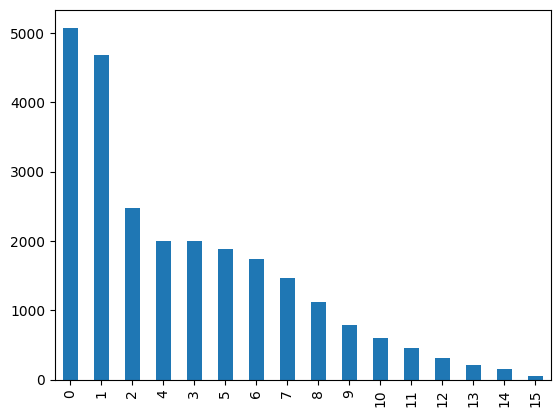

In [106]:
n_batches = epi.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches

In [107]:
# Perform PCA, UMAP, and leiden clustering
sc.pp.pca(epi, svd_solver="arpack", use_highly_variable=True)
sc.pp.neighbors(epi)
sc.tl.umap(epi)
sc.tl.leiden(epi, key_added="leiden_res0_25", resolution=0.25)

In [113]:
# Save the full dataset to the .raw layer, then filter the anndata object to only HVGs for integration
epi.raw = epi
adata = epi[:, epi.var["highly_variable"]].copy()
adata

AnnData object with n_obs × n_vars = 5830 × 6000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'BBKNN', 'H

In [115]:
import numpy as np
import scanpy as sc
from scib_metrics.benchmark import Benchmarker
%matplotlib inline

In [69]:
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

In [71]:
# Run Scanorama integration

# List of adata per batch
batch_cats = adata.obs['batch'].unique()
adata_list = [adata[adata.obs['batch'] == b].copy() for b in batch_cats]
scanorama.integrate_scanpy(adata_list)

adata.obsm["Scanorama"] = np.zeros((adata.shape[0], adata_list[0].obsm["X_scanorama"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["Scanorama"][adata.obs['batch'] == b] = adata_list[i].obsm["X_scanorama"]

Found 6000 genes among all datasets
[[0.         0.76076555 0.         0.06698565 0.         0.
  0.         0.         0.         0.         0.00956938 0.
  0.         0.         0.        ]
 [0.         0.         0.92276423 0.30081301 0.07723577 0.
  0.         0.         0.         0.         0.00813008 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.41055046 0.51146789 0.
  0.00787402 0.01633987 0.         0.         0.03899083 0.
  0.01376147 0.         0.        ]
 [0.         0.         0.         0.         0.56528926 0.40853659
  0.02362205 0.00653595 0.00331126 0.         0.02085071 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.94512195
  0.29133858 0.25816993 0.14569536 0.10894942 0.03669725 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.51219512 0.43292683 0.25       0.01829268 0.00609756 0.
  0.         0.         0.        ]
 [0.        

In [ ]:
# Run pyliger integration

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs['batch'] == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs['batch'] == b] = liger_data.adata_list[i].obsm["H_norm"]

In [ ]:
# Run Harmony integration
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="batch")

In [116]:
# Run scVI integration 
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, gene_likelihood="nb", n_layers=2, n_latent=30)
vae.train()
adata.obsm["scVI"] = vae.get_latent_representation()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [05:46<00:00,  1.16it/s, v_num=1, train_loss_step=3.65e+3, train_loss_epoch=3.68e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [05:46<00:00,  1.16it/s, v_num=1, train_loss_step=3.65e+3, train_loss_epoch=3.68e+3]


In [ ]:
# Run BBKNN integration
batch_key = 'batch'
adata_bbknn = adata.copy()
neighbors_within_batch = 25 if adata_bbknn.n_obs > 100000 else 3
neighbors_within_batch
adata_bbknn.X = adata_bbknn.layers["log1p_norm"].copy()
sc.pp.pca(adata_bbknn)
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn.obsm['BBKNN'] = adata_bbknn.obsm['X_umap'].copy()

In [ ]:
# Run the benchmarking. scVI was found to be the best the best-performing method at harmonising epicardial cells across datasets and species
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=['Unintegrated','BBKNN', 'Harmony', 'LIGER', 'Scanorama', 'scVI'],
    n_jobs=30,
)
bm.benchmark()

In [117]:
# Build the neighborhood graph using scVI-calculated latent embedding, run UMAP and leiden clustering
sc.pp.neighbors(adata, use_rep="scVI")
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata, key_added="leiden_res1", resolution=1.0)

In [121]:
# recover the original complete anndata object
adata2 = adata.raw.to_adata()
adata2

AnnData object with n_obs × n_vars = 5830 × 25011
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', '_scvi_uuid', '_scv

In [122]:
adata2.layers['counts'] = adata2.X.copy()
scales_counts = sc.pp.normalize_total(adata2, target_sum=None, inplace=False)
# log1p transform
adata2.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/mnt/sdb/qdang/micromamba/envs/sc

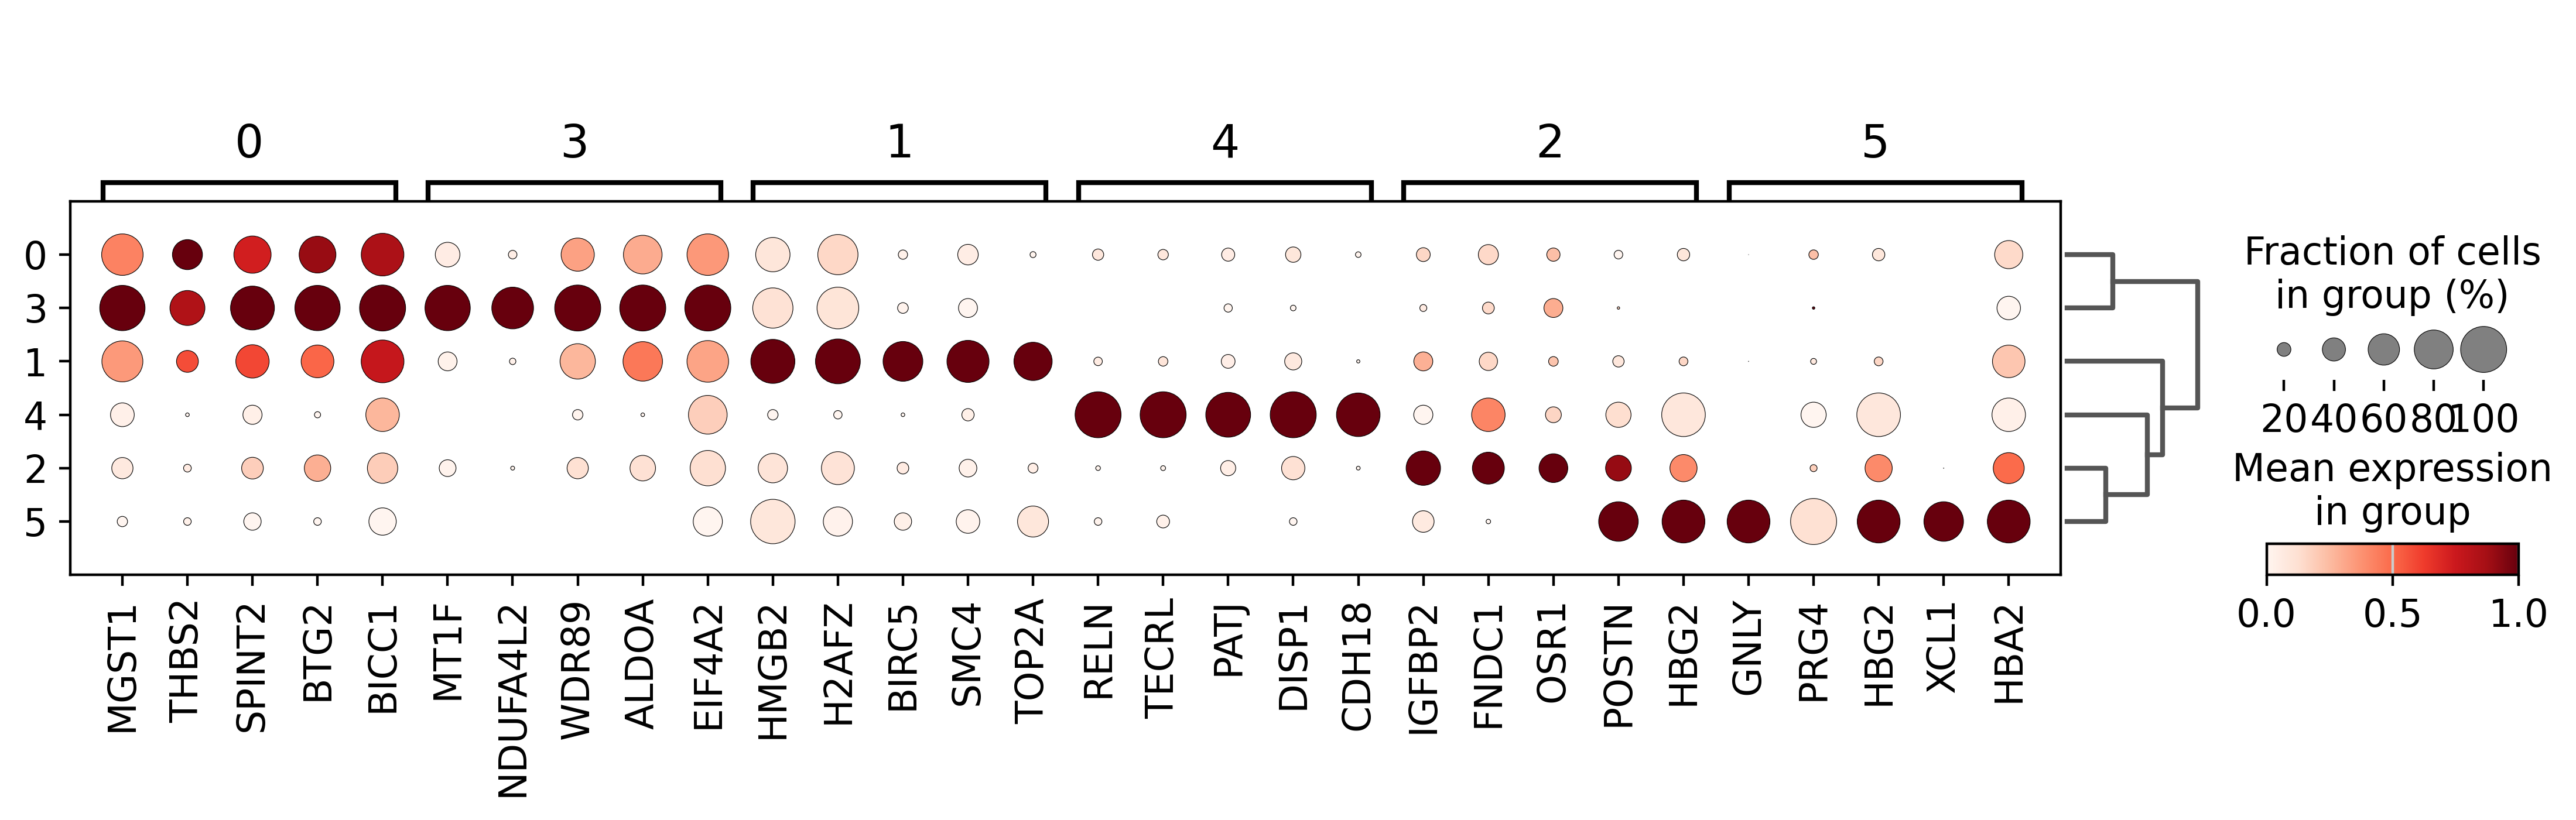

In [ ]:
sc.tl.dendrogram(adata2, groupby="leiden_res0_25")
sc.tl.rank_genes_groups(
    adata2, groupby="leiden_res0_25", method="wilcoxon", key_added="dea_leiden_0_25", use_raw=False
)
sc.pl.rank_genes_groups_dotplot(
    adata2, groupby="leiden_res0_25", standard_scale="var", n_genes=5, key="dea_leiden_0_25"
)

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What

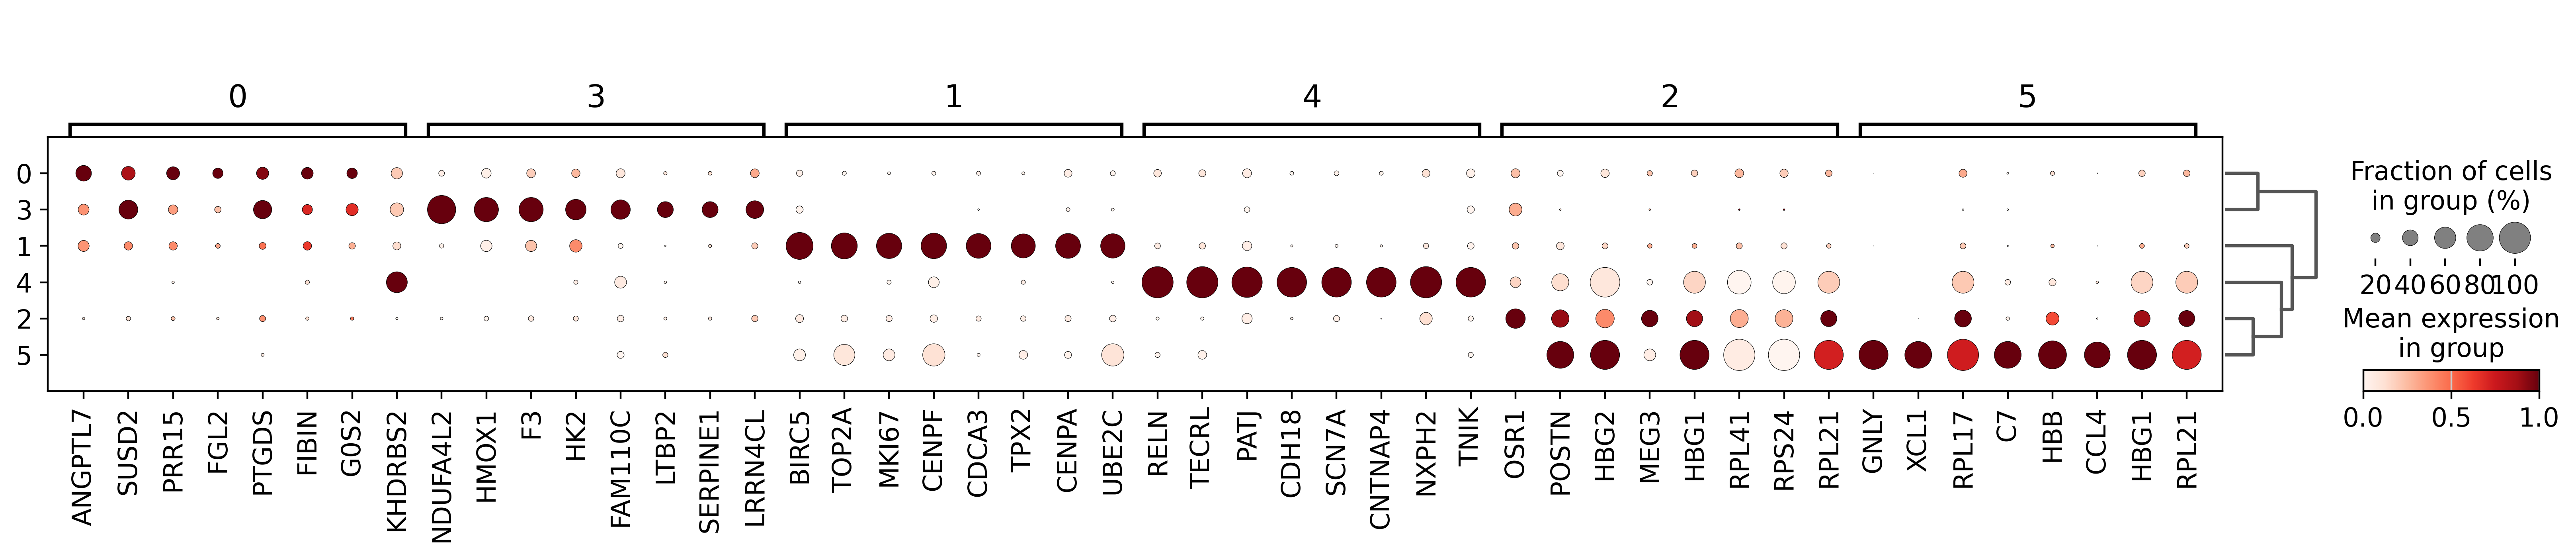

In [ ]:
# Cluster 5 highly expresses several hemoglobin genes and should be removed
sc.tl.filter_rank_genes_groups(
    adata2,
    min_in_group_fraction=0.2,
    max_out_group_fraction=0.2,
    key="dea_leiden_0_25",
    key_added="dea_leiden_0_25_filtered",
)
sc.pl.rank_genes_groups_dotplot(
    adata2,
    groupby="leiden_res0_25",
    standard_scale="var",
    n_genes=8,
    key="dea_leiden_0_25_filtered",
)

In [ ]:
adata

AnnData object with n_obs × n_vars = 5830 × 25011
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Species_colors', '_scvi_manager_uuid', '_scvi_uuid

In [ ]:
adata2 = adata[-adata.obs['leiden_res0_25'].isin(['5'])]
adata2

View of AnnData object with n_obs × n_vars = 5808 × 25011
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Species_colors', '_scvi_manager_uuid', '_s

In [ ]:
# Normalise again after subsetting
scales_counts = sc.pp.normalize_total(adata2, target_sum=None, inplace=False)
adata2.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
# Run dimensionality reduction and clustering again
sc.pp.neighbors(adata2, use_rep='scVI')
sc.tl.umap(adata2)
sc.tl.leiden(adata2, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata2, key_added="leiden_res1", resolution=1.0)

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


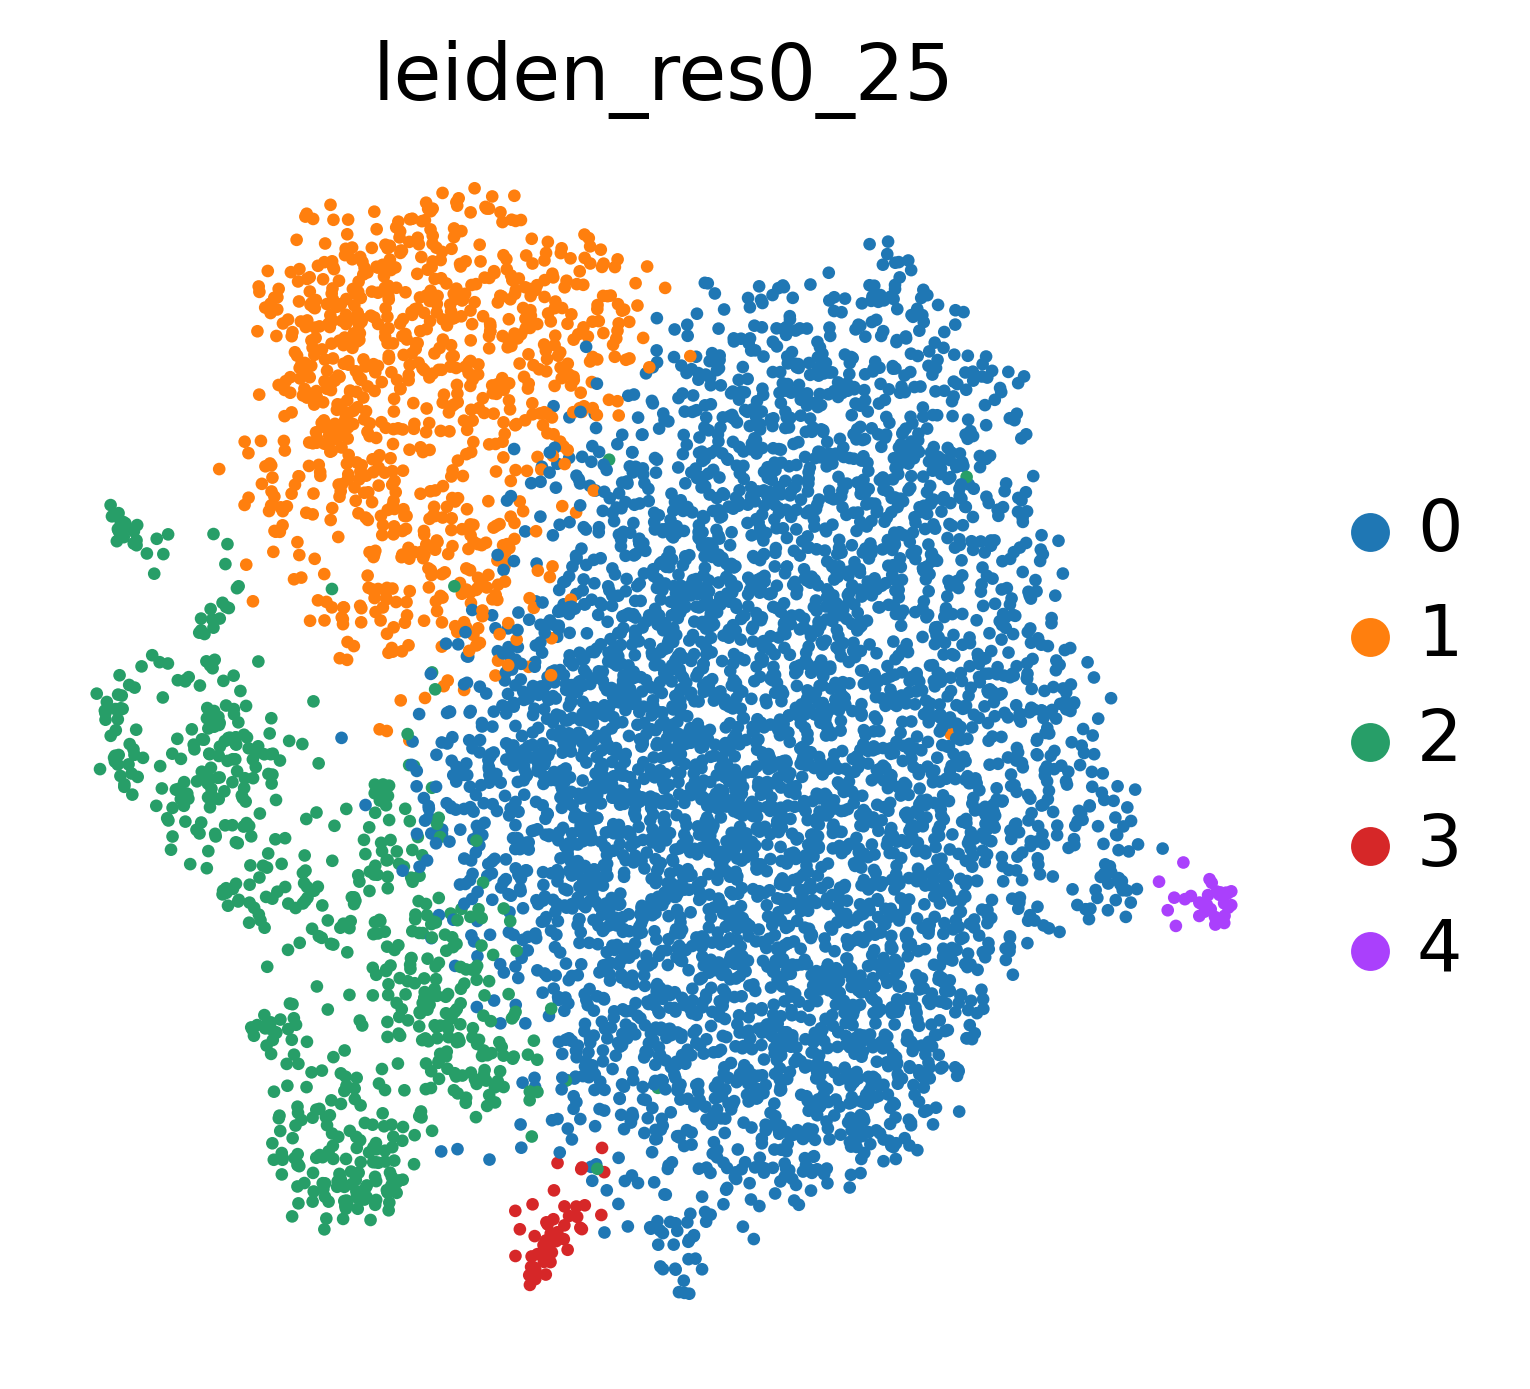

In [ ]:
sc.pl.umap(adata2, color=['leiden_res0_25'], layer='log1p_norm')

/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:135: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/mnt/sdb/qdang/micromamba/envs/scib_metrics/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/mnt/sdb/qdang/micromamba/envs/sc

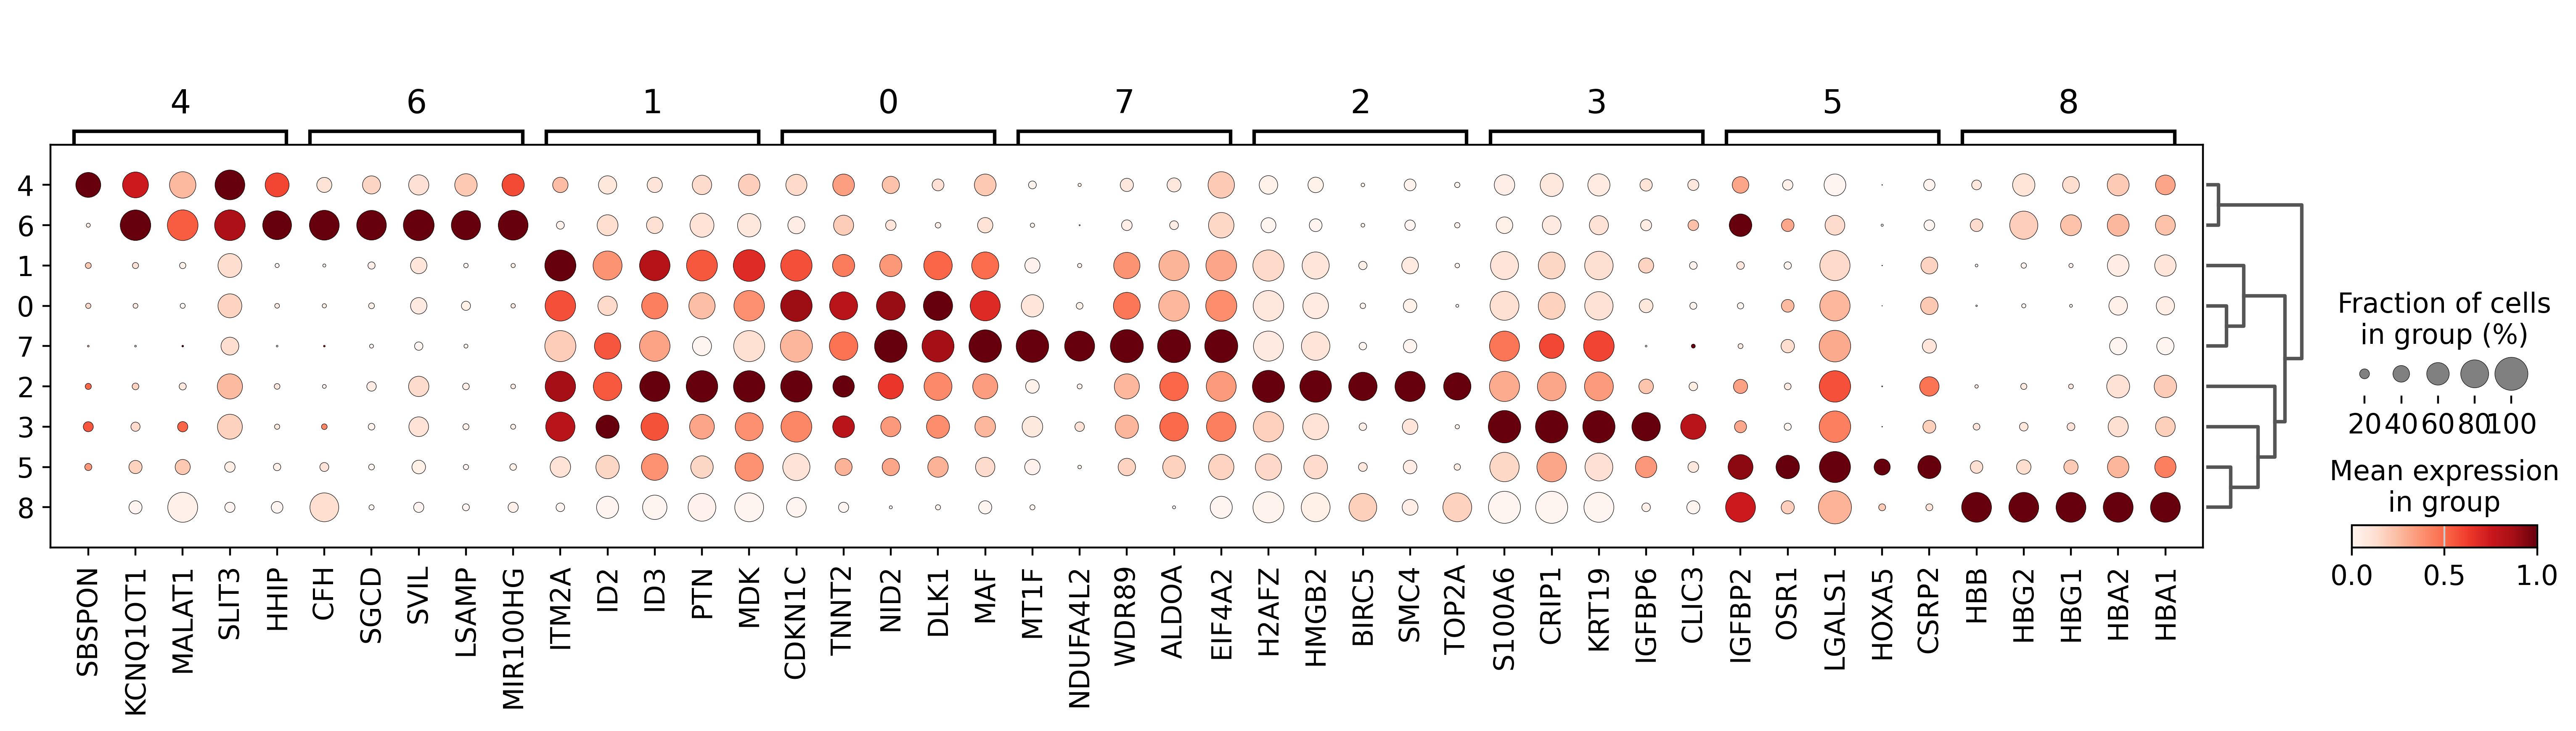

In [ ]:
# Cluster 8 again expresses high levels of hemoglobin genes and should be removed 
sc.tl.dendrogram(adata2, groupby="leiden_res0_5")
sc.tl.rank_genes_groups(
    adata2, groupby="leiden_res0_5", method="wilcoxon", key_added="dea_leiden_0_5"
)
sc.pl.rank_genes_groups_dotplot(
    adata2, groupby="leiden_res0_5", standard_scale="var", n_genes=5, key="dea_leiden_0_5"
)

In [ ]:
adata2

AnnData object with n_obs × n_vars = 5808 × 25011
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Species_colors', '_scvi_manager_uuid', '_scvi_uuid

In [ ]:
# Remove contaminating cells
adata3 = adata2[-adata2.obs['leiden_res0_5'].isin(['8'])]
adata3

View of AnnData object with n_obs × n_vars = 5784 × 25011
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'replicates', 'scDblFinder_score', 'scDblFinder_class', 'batch', 'n_genes', 'size_factors', 'leiden_res0_25', 'celltypist_cell_label_PRJNA795900', 'celltypist_conf_score_PRJNA795900', '_scvi_batch', '_scvi_labels', 'leiden_res0_5', 'leiden_res1', 'cell type', 'cell type 2', 'time', 'region', 'Sample', 'percent.mt', 'EXPT', 'barcode', 'Batch', 'celltypist_cell_label_kundaje', 'celltypist_conf_score_kundaje', 'Species', 'cell_type'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Species_colors', '_scvi_manager_uuid', '_s

In [ ]:
# Normalise again after subsetting
scales_counts = sc.pp.normalize_total(adata3, target_sum=None, inplace=False)
adata3.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)
sc.pp.neighbors(adata3, use_rep='scVI')
sc.tl.umap(adata3)
sc.tl.leiden(adata3, key_added="leiden_res0_25", resolution=0.25)
sc.tl.leiden(adata3, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(adata3, key_added="leiden_res1", resolution=1.0)

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


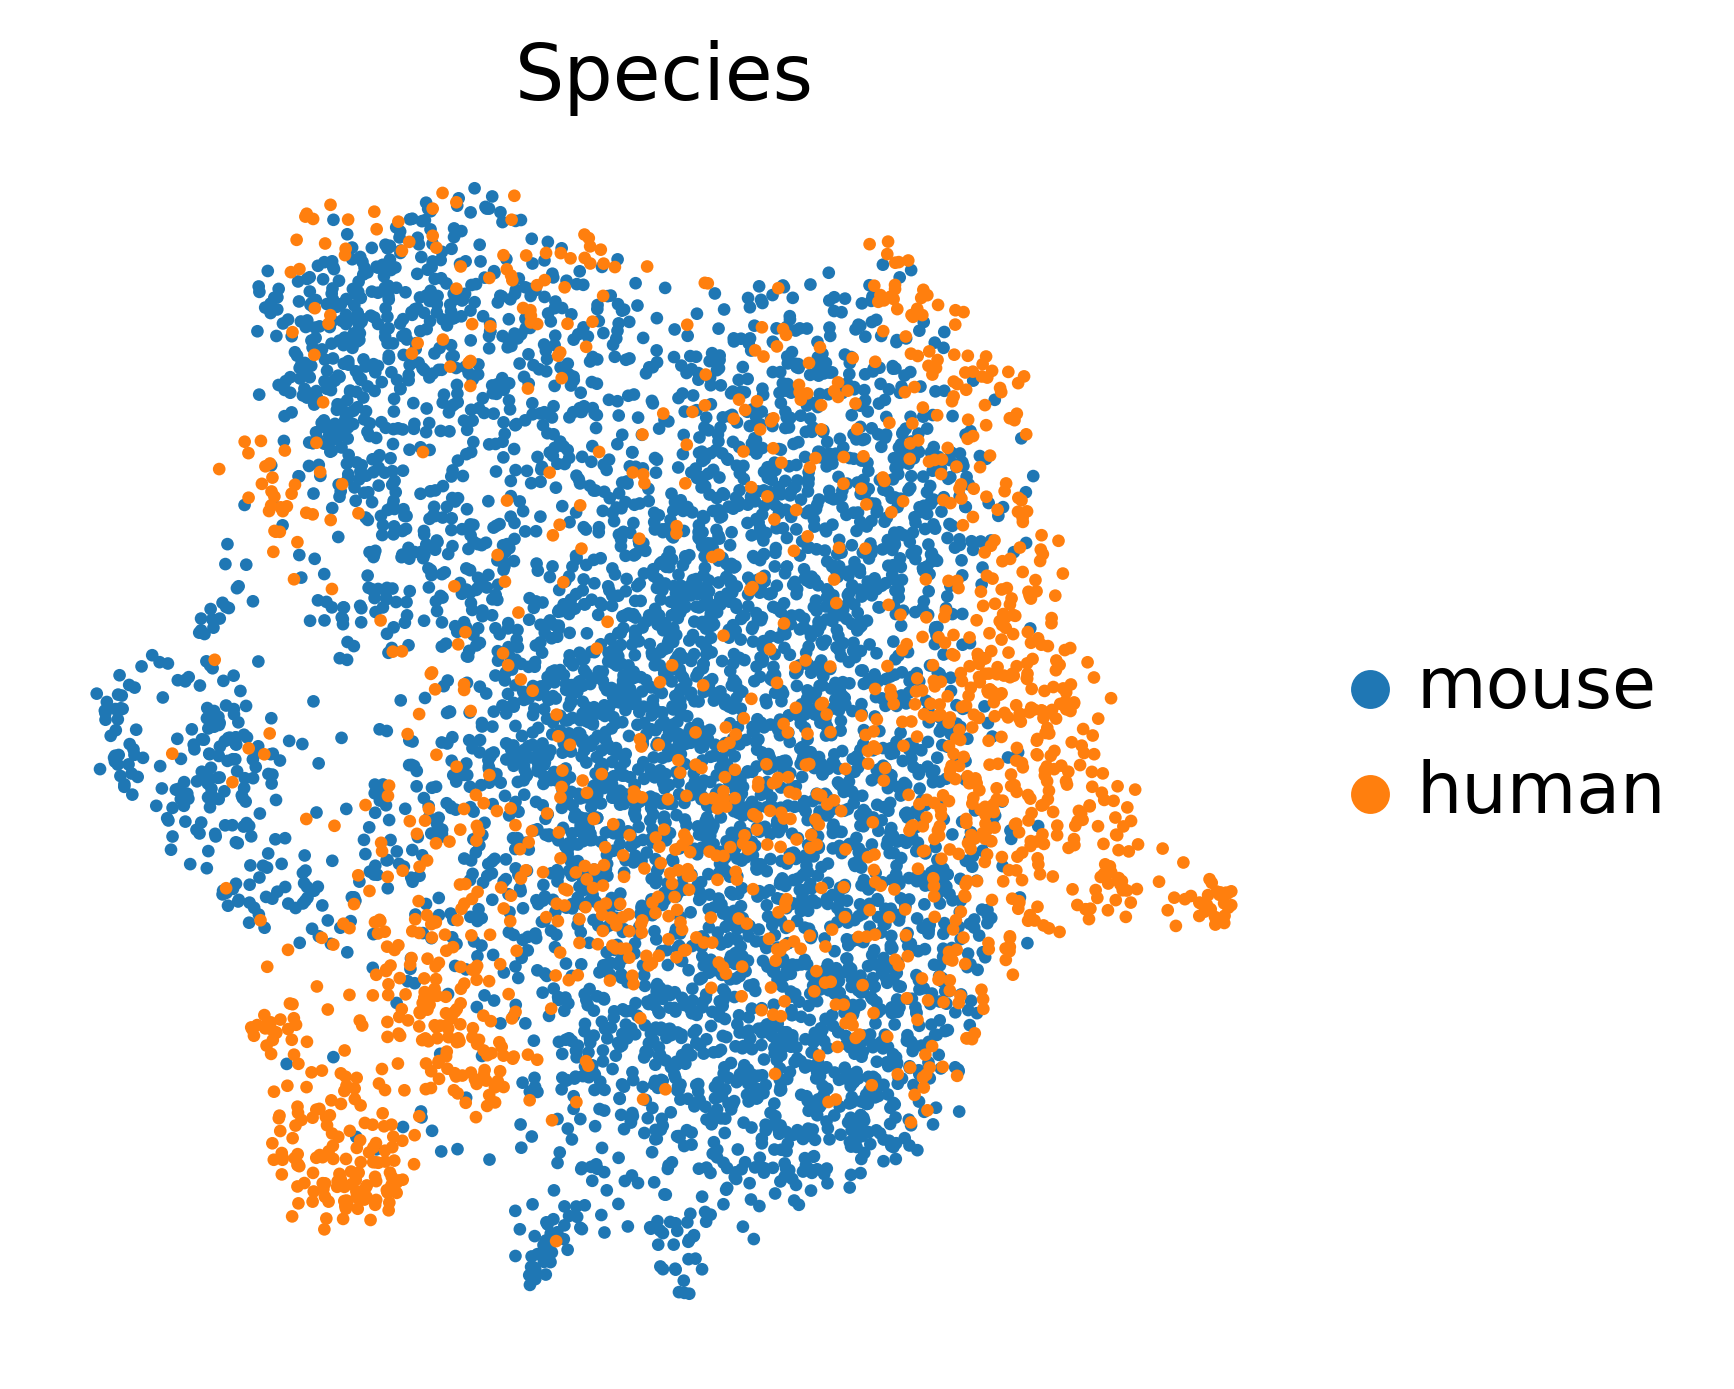

In [ ]:
sc.pl.umap(adata2, color=['Species'], layer='log1p_norm',use_raw=False, save='epi_crosss_species_umap.pdf')

/mnt/sdb/qdang/micromamba/envs/bioinfo/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


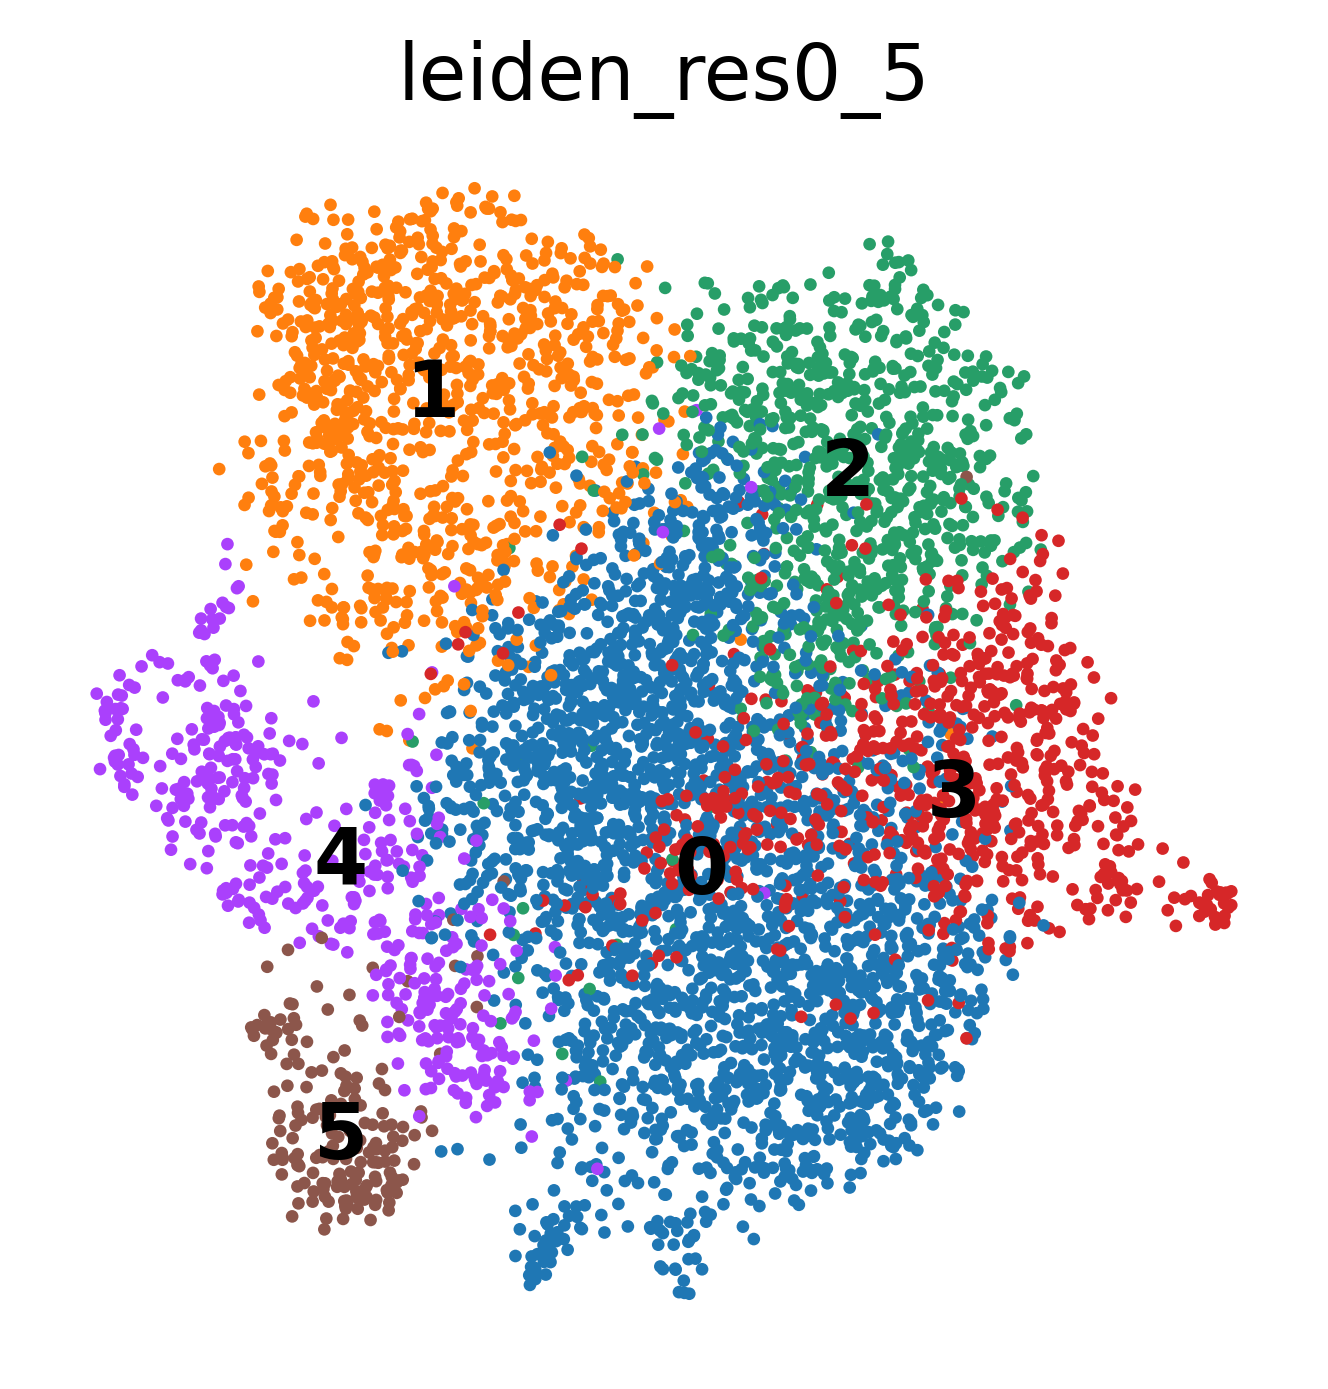

In [ ]:
sc.pl.umap(adata2, color=['leiden_res0_5'], layer='log1p_norm',use_raw=False, legend_loc='on data')